# Citations over time

In [8]:
# You can ignore this cell, it just imports the different modules you need :smile:
from glob import glob
from IPython.display import display # Use this to display multiple outputs within a cell
import itertools as it
import json
import matplotlib.pylab as plt
import matplotlib.ticker as ticker
%matplotlib inline
import numpy as np
import os
import pandas as pd
import requests
import seaborn as sns
sns.set_style('white')
sns.set_context('notebook',font_scale=1.5)
from scipy.stats import ttest_ind, ttest_rel, pearsonr, spearmanr, linregress, ttest_1samp
import statsmodels.api as sm
from statsmodels.sandbox.stats.multicomp import fdrcorrection0 as fdr
import sys
import datetime as dt

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Get the data

In [2]:
# Taken from a question on StackOverflow:
# https://stackoverflow.com/questions/16694907/how-to-download-large-file-in-python-with-requests-py

def download_file(url, filename):
    local_filename = '../data/{}'.format(filename)
    # NOTE the stream=True parameter
    r = requests.get(url, stream=True)
    with open(local_filename, 'wb') as f:
        for chunk in r.iter_content(chunk_size=1024): 
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)
                #f.flush() commented by recommendation from J.F.Sebastian
    print(local_filename)

In [3]:
eupmc_githubdotcom_f_name = 'eupmc_results_githubdotcom.json'
eupmc_githubdotcom_url = 'https://www.dropbox.com/s/4iwwb3mr46pdx2h/{}?dl=1'.format(eupmc_githubdotcom_f_name)

eupmc_zenodo_f_name = 'eupmc_results_zenodo.json'
eupmc_zenodo_url = 'https://www.dropbox.com/s/r7132d9utv17l8j/{}?dl=1'.format(eupmc_zenodo_f_name)

eupmc_figshare_f_name = 'eupmc_results_figshare.json'
eupmc_figshare_url = 'https://www.dropbox.com/s/yolaxezf4yy52fv/{}?dl=1'.format(eupmc_figshare_f_name)

file_url_dict = {}

file_url_dict['githubdotcom'] = (eupmc_githubdotcom_f_name, eupmc_githubdotcom_url)
file_url_dict['zenodo'] = (eupmc_zenodo_f_name, eupmc_zenodo_url)
file_url_dict['figshare'] = (eupmc_figshare_f_name, eupmc_figshare_url)


In [4]:
if not os.path.isdir('../data'):
    os.path.makedirs('../data')

for term, (f_name, url) in file_url_dict.items():
    
    if not os.path.isfile('../data/{}'.format(f_name)):
        download_file(url, f_name)
    else:
        print('eupmc {} data already downloaded'.format(term))

eupmc githubdotcom data already downloaded
eupmc zenodo data already downloaded
../data/eupmc_results_figshare.json


## Term occurence over time

In [5]:
def read_in_data(f_name):

    with open('../data/{}'.format(f_name), encoding="utf8") as f:
        data = json.load(f)
          
    pub_dates = [ dt.datetime.strptime(article['firstPublicationDate'][0], '%Y-%m-%d') 
              for article 
              in data ]

    df = pd.DataFrame({'pub-date' : pub_dates})
    
    return df

In [6]:
def plot_histogram(df, term):
    
    df.columns = [term]
    
    fig, ax = plt.subplots()

    # Helpful command from
    # https://stackoverflow.com/questions/27365467/can-pandas-plot-a-histogram-of-dates
    ax = df.groupby([df[term].dt.year, 
                     df[term].dt.month]).count().plot(kind="bar",
                                                            ax=ax)

    ax.set_xlabel('Date')
    
    labels = []
    
    for label in ax.xaxis.get_ticklabels():
        x = label.get_text()
        x = x[1:-1]
        (year, month) = x.split(',')
        labels += [year]
        if month == ' 1':
            label.set_visible(True)
            label.set_rotation(45)
        else:
            label.set_visible(False)
            
    ax.set_xticklabels(labels)
    sns.despine()

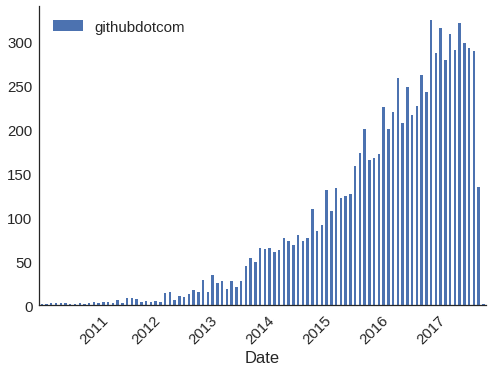

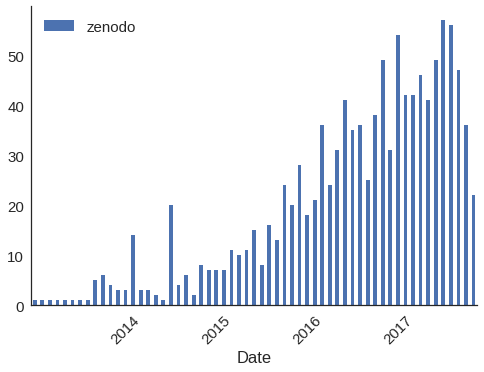

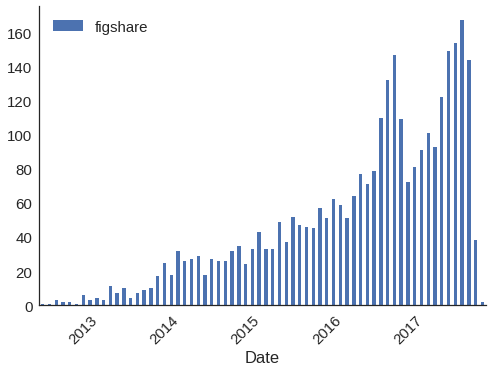

In [9]:
for term, (f_name, url) in file_url_dict.items():
    df = read_in_data(f_name)
    plot_histogram(df, term)

# Affiliations

In [10]:
with open('../data/{}'.format(eupmc_githubdotcom_f_name), encoding="utf8") as f:
    github = json.load(f)
with open('../data/{}'.format(eupmc_zenodo_f_name), encoding="utf8") as f:
    zenodo = json.load(f)    
with open('../data/{}'.format(eupmc_figshare_f_name), encoding="utf8") as f:
    figshare = json.load(f)

In [11]:
def affiliations(data):
    affiliation_list = []
    for article in data:
        try:
            for x in article['authorList']:
                for y in x['author']:
                    try:
                        affiliation_list.append(y['affiliation'][0].split(',')[0])
                    except KeyError:
                        pass
        except:
            pass
    from collections import Counter
    affiliations = Counter(affiliation_list)
    return affiliations.most_common()

In [12]:
affiliations(zenodo)

[('Department of Biology', 100),
 ('Department of Genetics', 70),
 ('Department of Medicine', 65),
 ('Department of Computer Science', 64),
 ('Department of Neurology', 53),
 ('Biodiversity Institute of Ontario', 52),
 ('European Molecular Biology Laboratory', 50),
 ('European Bioinformatics Institute (EMBL-EBI)', 47),
 ('Department of Psychology', 39),
 ('Department of Pathology', 39),
 ('Department of Chemistry', 35),
 ('Department of Materials', 34),
 ('Diamond Light Source Ltd', 34),
 ('Department of Biological Sciences', 33),
 ('Department of Psychiatry', 33),
 ('RCSB Protein Data Bank', 32),
 ('Department of Life Science Informatics', 31),
 ('Department of Biochemistry', 30),
 ('Department of Human Genetics', 29),
 ('Department of Physics', 29),
 ('National Center for Emerging and Zoonotic Infectious Diseases and National Center for Immunization and Respiratory Diseases',
  28),
 ('Department of Surgery', 25),
 ('Department of Statistics', 25),
 ('Bioinformatics Group', 24),
 ('D